<a href="https://colab.research.google.com/github/kwakyosong/KOSA_KDT/blob/main/KDT_day5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import models, datasets , transforms
from torch.utils.data import DataLoader


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# GoogleNet 이미지 분류

# model

# dir (models)
# weight값과 model이 따로 있음
weights = models.GoogLeNet_Weights.IMAGENET1K_V1
net = models.googlenet(weights=weights) # 굳이 따로 하는 이유 ?
net = net.to(device)

In [ ]:
# Finetuing없이 사용
from torchvision.io import read_image # 그림 읽어서 tensor로 자동 변환

net.eval()

filename = "/content/진도개.jpg"
img = read_image(filename)
img = img.to(device)

print('type = ' , type(img))
print('shape = ' , img.shape)

# 학습할때 했던 이미지 사이즈로 만들어줘야 잘 맞춤
preprocess = weights.transforms()
batch = preprocess(img).unsqueeze(0).to(device)
print(batch.shape)

RuntimeError: [Errno 2] No such file or directory: '/content/진도개.jpg'

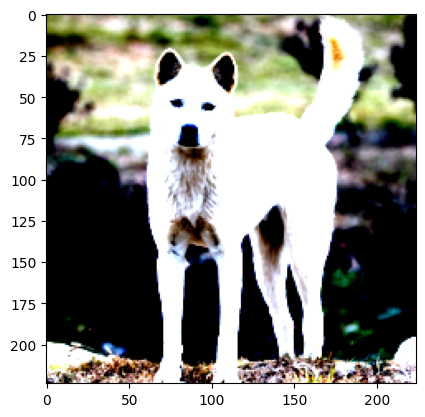

In [ ]:
processed_img = batch[0]
processed_img.shape
plt_img = torch.clamp(processed_img.permute(1,2,0),0,1)
plt_img.shape

plt.imshow(plt_img.cpu())

In [ ]:
prediction = net(batch).softmax(dim = 1)
# print(prediction) - 여기까지가 인공지능이 해주는 역할 끝

class_id = prediction.argmax(1).item()
print("class_id = " , class_id) # 167번

# weights.meta에 들어 있음

category_name = weights.meta["categories"][class_id]
prob = prediction[0][class_id].item()
print(category_name , prob)

class_id =  270
white wolf 0.33391666412353516


In [ ]:
# 모델은 있으니 이미지를 학습시켜서 새 이미지로 추론한다.  ==> 전이 학습
# Resnet Transfer learning (전이학습)
weights = models.ResNet50_Weights.IMAGENET1K_V2
net = models.resnet50(weights=weights)

In [ ]:
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
from PIL.Image import Transform
transform = transforms.Compose([
    transforms.Resize(224) ,
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.2)
])

train_set = datasets.CIFAR100(
    root = "./data",
    train= True,
    transform = transform ,
    download = True
)

test_set = datasets.CIFAR100(
    root = "./data",
    train= False,
    transform = transform ,
    download = True
)

In [ ]:
num_ftrs = net.fc.in_features
print(f"Number of input features to fc layer: {num_ftrs}") # 2048이 출력되어야 함

net.fc = nn.Linear(net.fc.in_features,100)
net = net.to(device) # 모델을 GPU로 이동

Number of input features to fc layer: 2048


In [ ]:
## Data : CIFAR100
## Model : ResNet10 transfer learning

## learning parameter (학습 파라메터 설정)
lr = 0.001

# 손실함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수
optimizer = optim.SGD(net.parameters() , lr = lr , momentum= 0.9)

# 학습 과정 저장
history = np.zeros((0,5))

In [ ]:
from tqdm import tqdm # 학습 진행률 확인을 위한 라이브러리

# 데이터 로더 설정
BATCH_SIZE = 32 # 배치 크기 설정
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# --- 3. 학습 파라미터 및 설정 ---
lr = 0.001
num_epochs = 10

# 손실함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수 (optimizer)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# 학습 과정 저장을 위한 리스트 (history는 numpy 배열보다 파이썬 리스트가 더 편리)
history = []


# --- 4. 학습 루프 실행 (Training Loop) ---

print(f"\nStarting training on {device}...")

for epoch in range(num_epochs):
    net.train() # 모델을 학습 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # tqdm으로 진행률 표시
    for i, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # 데이터를 GPU로 이동

        # 옵티마이저 초기화 (이전 배치의 기울기 삭제)
        optimizer.zero_grad()

        # 순전파 (Forward pass)
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # 역전파 (Backward pass) 및 가중치 최적화
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # 에포크별 평균 손실 및 정확도 계산
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train

    # --- 테스트 (검증) ---
    net.eval() # 모델을 평가 모드로 설정
    correct_test = 0
    total_test = 0
    with torch.no_grad(): # 테스트 시에는 기울기 계산 불필요
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    # history 저장 (Epoch, Loss, Train Acc, Test Acc)
    history.append([epoch+1, epoch_loss, epoch_acc, test_acc])

print('Finished Training')

# 학습된 모델 저장 (선택 사항)
torch.save(net.state_dict(), 'resnet50_cifar100_transfer_learning.pth')
print("Model saved.")


Starting training on cuda...


Epoch 1, Loss: 2.2081, Train Acc: 49.81%, Test Acc: 76.73%


Epoch 2, Loss: 0.7187, Train Acc: 78.47%, Test Acc: 81.18%


Epoch 3, Loss: 0.4828, Train Acc: 85.14%, Test Acc: 83.06%


Epoch 4, Loss: 0.3379, Train Acc: 89.74%, Test Acc: 83.97%


Epoch 5, Loss: 0.2356, Train Acc: 92.96%, Test Acc: 84.14%


Epoch 6, Loss: 0.1671, Train Acc: 95.20%, Test Acc: 84.15%


Epoch 7, Loss: 0.1196, Train Acc: 96.75%, Test Acc: 84.39%


Epoch 8, Loss: 0.0908, Train Acc: 97.67%, Test Acc: 84.68%


Epoch 9, Loss: 0.0699, Train Acc: 98.36%, Test Acc: 84.47%


Epoch 10, Loss: 0.0514, Train Acc: 98.92%, Test Acc: 84.57%
Finished Training
Model saved.


In [39]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import os

# --- 설정 ---
MODEL_PATH = 'resnet50_cifar100_transfer_learning.pth'
IMAGE_PATH = 'cheery.jpg' # 테스트할 이미지 파일 경로
NUM_CLASSES = 100
# CIFAR-100 클래스 이름 목록 (데이터셋 공식 문서에서 가져옴)
CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'rat', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# GPU 사용 설정 (가능하다면)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# --- 1. 모델 구조 정의 및 가중치 불러오기 ---

# ResNet50 모델의 뼈대(아키텍처)를 먼저 정의 (weights=None으로 빈 모델 생성)
net = models.resnet50(weights=None)

# 학습 시와 동일하게 마지막 FC 층을 100개 클래스용으로 교체
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# 저장된 가중치 파일 로드
if os.path.exists(MODEL_PATH):
    net.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print(f"Model weights loaded from {MODEL_PATH}")
else:
    print(f"Error: Model file '{MODEL_PATH}' not found.")
    exit()

# 모델을 평가 모드로 설정하고 GPU/CPU로 이동
net.eval()
net.to(device)

# --- 2. 이미지 전처리 (학습 시와 동일한 transform 사용) ---

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.2) # 학습 시 사용한 정규화 값
])

# 이미지 불러오기 및 변환
if os.path.exists(IMAGE_PATH):
    image = Image.open(IMAGE_PATH).convert('RGB')
    image.show() # 이미지 미리보기 (PIL이 설치되어 있고 환경이 지원될 경우)

    input_tensor = transform(image)
    # 모델 입력은 [배치크기, 채널, 높이, 너비] 형태여야 함 -> 배치 차원 추가 (unsqueeze(0))
    input_batch = input_tensor.unsqueeze(0)
    input_batch = input_batch.to(device) # 데이터를 GPU/CPU로 이동
    print(f"Image '{IMAGE_PATH}' processed.")
else:
    print(f"Error: Test image file '{IMAGE_PATH}' not found.")
    exit()


# --- 3. 예측 실행 (추론) ---

with torch.no_grad(): # 추론 시에는 기울기 계산 안 함
    output = net(input_batch)

# 결과 해석
# output은 각 클래스에 대한 점수(logits)를 포함
probabilities = torch.nn.functional.softmax(output[0], dim=0) # 확률로 변환
top5_prob, top5_idx = torch.topk(probabilities, 5) # 상위 5개 예측 결과 가져오기

print("\n--- 예측 결과 (Top 5) ---")
for i in range(5):
    prob = top5_prob[i].item() * 100
    label_idx = top5_idx[i].item()
    class_name = CIFAR100_CLASSES[label_idx]
    print(f"{i+1}. {class_name} (확률: {prob:.2f}%)")



Running on device: cuda:0
Model weights loaded from resnet50_cifar100_transfer_learning.pth
Image 'cheery.jpg' processed.

--- 예측 결과 (Top 5) ---
1. pear (확률: 85.26%)
2. orange (확률: 6.29%)
3. apple (확률: 5.73%)
4. bowl (확률: 0.80%)
5. snail (확률: 0.32%)


In [2]:
!pip install -qU ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 109.8 MB/s eta 0:00:00


In [3]:
import os
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

import ultralytics
import yaml

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [30]:
img_dirs = '/content/drive/MyDrive/2025년 한기대 KDT AI중급/day5/fig'

## YOLO OBJECT DETECTION
img_path = os.path.join(img_dirs , "animals.jpg")
img = cv2.imread(img_path)

In [9]:
print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(576, 768, 3)


In [31]:
model = ultralytics.YOLO("yolo11x.pt")

In [34]:
detection = model(img, verbose=True)[0]



0: 480x640 4 birds, 2 horses, 9 cows, 1 elephant, 121.2ms
Speed: 23.1ms preprocess, 121.2ms inference, 63.9ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
print("detection = \n" , detection)

In [28]:
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ]

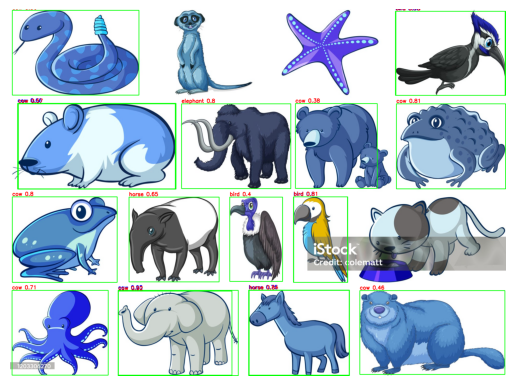

In [39]:
# 최소 신뢰도(Confidence) 임계값 설정 (60%)
CONFIDENCE_THRESHOLD = 0.5

# --- 2. 감지 결과 반복 처리 및 시각화 ---
# 감지된 모든 바운딩 박스 데이터를 리스트로 변환하여 반복
for data in detection.boxes.data.tolist():

        # 리스트의 다섯 번째 요소 (인덱스 4)는 신뢰도(확률) 값
        confidence = data[4]
        if confidence < CONFIDENCE_THRESHOLD:
            continue

        # 바운딩 박스 좌표 추출 (xmin, ymin, xmax, ymax) 및 정수형으로 변환
        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        label = int(data[5]) # 리스트의 여섯 번째 요소 (인덱스 5)는 클래스 ID
        # 바운딩 박스를 이미지에 그림 (녹색, 두께 2)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        # 클래스 이름과 신뢰도를 문자열로 구성
        cv2.putText(img, classNames[label]+ ' ' +str(round(confidence, 2)),
        (xmin, ymin-5), cv2.FONT_ITALIC, 0.7, (0, 0, 255), 2)

# --- 3. 이미지 출력 (Matplotlib) ---
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Figure 객체 가져오기 및 전체 화면 설정
fig = plt.figure() # 새로운 Figure 생성
fig_manager = plt.get_current_fig_manager() # 현재 Figure의 관리자 가져오기
fig_manager.full_screen_toggle() # 전체 화면 모드 활성화/비활성화 (토글)

# 이미지 표시 설정
plt.imshow(img)
plt.grid(None)
plt.axis("off")

plt.show()